# Analysis of Indentation and Tensile plasticity data

This notebook documents the analysis of experimental data gathered from both indentation and tensile tests performed on metallic samples. The aim is to characterise the plastic deformation behavior of the materials, compare different testing techniques, and relate mechanical properties to microstructural features.

**Key objectives:**
- Convert force-displacement data from tensile tests into nominal and true stress-strain curves.
- Fit the Voce constitutive law to the experimental data to extract plasticity parameters.
- Analyze and compare results from conventional hardness measurements (Vickers, Brinell) and advanced indentation plastometry.
- Discuss the relative merits, limitations, and transferability of each technique for material characterisation.
- Relate observed mechanical behavior to microstructural features and propose further investigations if needed.

This analysis supports a deeper understanding of plastic deformation, work hardening, and the relationship between mechanical properties and microstructure, which are critical for materials selection and design in engineering applications.

In [1]:
# Imports

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import re
from pathlib import Path

In [2]:
# Load data files and clean

base = Path("/Users/thomasfish/Desktop/University_Work/II_Materials/P2_Plasticity/Data")
data_files = ["A1", "A2", "A3", "B1", "B2", "B3", "S1", "S2", "S3"]

def load_one(path: Path) -> pd.DataFrame:
    """Load a CSV with 1-column offset header issue and fix it."""
    # --- 1) Read header line
    with open(path, "r", encoding="utf-8-sig") as f:
        raw_header = f.readline().rstrip("\r\n")

    # --- 2) Detect delimiter and clean header
    delim = "\t" if "\t" in raw_header else ","
    header_cells = re.split(r"[\t,]+", raw_header.strip())

    # Drop rogue first cell (like "1" or blank)
    if header_cells and (header_cells[0].strip() == "" or header_cells[0].strip().isdigit()):
        header_cells = header_cells[1:]

    cols = [c.strip() for c in header_cells]

    # --- 3) Read rest of file (no header)
    df = pd.read_csv(
        path,
        sep=delim,
        engine="python",
        skiprows=1,
        header=None,
        dtype=str,
        keep_default_na=False,
    )

    # --- 4) Drop leading empty column if present
    if df.shape[1] == len(cols) + 1:
        first_col = df.iloc[:, 0].replace(r"^\s*$", pd.NA, regex=True)
        if first_col.isna().all():
            df = df.iloc[:, 1:]

    # --- 5) Align column counts
    if df.shape[1] > len(cols):
        df = df.iloc[:, :len(cols)]
    elif df.shape[1] < len(cols):
        for _ in range(len(cols) - df.shape[1]):
            df[df.shape[1]] = pd.NA

    # --- 6) Assign headers and convert numerics
    df.columns = cols
    for c in df.columns:
        df[c] = pd.to_numeric(df[c].replace(r"^\s*$", pd.NA, regex=True), errors="coerce")

    df.reset_index(drop=True, inplace=True)
    return df

dfs = {}
for name in data_files:
    path = base / f"{name}.csv"
    df = load_one(path)
    dfs[name] = df
    globals()[name] = df  # create a separate DataFrame variable, e.g., A1, A2, B1, ...

print("Loaded data frames:")
for name in data_files:
    print(f"{name}: {dfs[name].shape}")


Loaded data frames:
A1: (4821, 6)
A2: (5064, 6)
A3: (4563, 6)
B1: (7834, 6)
B2: (8170, 6)
B3: (8792, 6)
S1: (11309, 6)
S2: (10922, 6)
S3: (11494, 6)


In [3]:
# Average the repeat experiments over time

def _find_time_col(df):
    for c in df.columns:
        if 'time' in str(c).lower():
            return c
    return df.columns[0]

def average_time_series(dfs, time_col=None):
    P = []
    for d in dfs:
        # pick time column per-DF (use provided name if present, else auto-detect)
        tc = time_col if (time_col is not None and time_col in d.columns) else _find_time_col(d)
        x = d.copy()
        x[tc] = pd.to_numeric(x[tc], errors='coerce')
        x = x.dropna(subset=[tc]).set_index(tc).sort_index()
        P.append(x)

    # union grid of all timestamps
    grid = sorted(set().union(*[p.index for p in P]))
    # align via interpolation, then average column-wise
    aligned = [p.reindex(grid).interpolate('index').ffill().bfill() for p in P]
    wide = pd.concat(aligned, axis=1, keys=range(len(aligned)))
    out = wide.groupby(level=1, axis=1).mean()
    out.index.name = (time_col or _find_time_col(dfs[0]))
    return out

# Use it (no hard-coded "Time/s"):
A_avg = average_time_series([A1, A2, A3])
B_avg = average_time_series([B1, B2, B3])
S_avg = average_time_series([S1, S2, S3])

A_avg.head(10)

/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50076/705901379.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  out = wide.groupby(level=1, axis=1).mean()
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50076/705901379.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  out = wide.groupby(level=1, axis=1).mean()
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50076/705901379.py:24: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  out = wide.groupby(level=1, axis=1).mean()


,Displacement/mm,Force/kN,Strain 1/%,Tensile displacement/mm,Tensile strain (Strain 1)/%
Time/s,,,,,
0.00,0.000000,0.018000,-0.065900,-0.032967,-0.065900
0.02,0.000200,0.018033,-0.065900,-0.032933,-0.065900
0.04,0.000900,0.019333,-0.065833,-0.032933,-0.065833
0.06,0.002000,0.023233,-0.065633,-0.032800,-0.065633
0.08,0.003300,0.029500,-0.065300,-0.032633,-0.065300
0.10,0.005033,0.037467,-0.064900,-0.032433,-0.064900
0.12,0.006800,0.047300,-0.064400,-0.032167,-0.064400
0.14,0.008400,0.057567,-0.063833,-0.031900,-0.063833
0.16,0.009933,0.067367,-0.063333,-0.031667,-0.063333


In [4]:
# Calculate true and engineering stress
# Tensile sample dimensions

# UPDATE
l = 0.0856
w = 0.0124
h = 0.00198

A_avg['Nom Stress/MPa'] = A_avg['Force/kN'] / ((w*h) * 1e3)
B_avg['Nom Stress/MPa'] = B_avg['Force/kN'] / ((w*h) * 1e3)
S_avg['Nom Stress/MPa'] = S_avg['Force/kN'] / ((w*h) * 1e3)

A_avg['True Stress/MPa'] = A_avg['Nom Stress/MPa'] * (1 + (A_avg['Tensile strain (Strain 1)/%']/100))
B_avg['True Stress/MPa'] = B_avg['Nom Stress/MPa'] * (1 + (B_avg['Tensile strain (Strain 1)/%']/100))
S_avg['True Stress/MPa'] = S_avg['Nom Stress/MPa'] * (1 + (S_avg['Tensile strain (Strain 1)/%']/100))

A_avg['True Strain/%'] = np.log(1 + (A_avg['Tensile strain (Strain 1)/%']/100)) * 100
B_avg['True Strain/%'] = np.log(1 + (B_avg['Tensile strain (Strain 1)/%']/100)) * 100
S_avg['True Strain/%'] = np.log(1 + (S_avg['Tensile strain (Strain 1)/%']/100)) * 100 

S_avg.head(10)

,Displacement/mm,Force/kN,Strain 1/%,Tensile displacement/mm,Tensile strain (Strain 1)/%,Nom Stress/MPa,True Stress/MPa,True Strain/%
Time/s,,,,,,,,
0.00,0.000000,0.027600,0.000100,0.000033,0.000100,1.124145,1.124146,0.000100
0.02,0.000200,0.027700,0.000100,0.000033,0.000100,1.128218,1.128219,0.000100
0.04,0.000767,0.029367,0.000167,0.000067,0.000167,1.196101,1.196103,0.000167
0.06,0.001633,0.033567,0.000233,0.000100,0.000233,1.367166,1.367169,0.000233
0.08,0.002900,0.039833,0.000333,0.000167,0.000333,1.622407,1.622412,0.000333
0.10,0.004633,0.047967,0.000533,0.000267,0.000533,1.953677,1.953687,0.000533
0.12,0.006200,0.057667,0.000767,0.000367,0.000767,2.348756,2.348774,0.000767
0.14,0.007833,0.067633,0.001000,0.000467,0.001000,2.754698,2.754725,0.001000
0.16,0.009433,0.077500,0.001200,0.000633,0.001200,3.156566,3.156604,0.001200


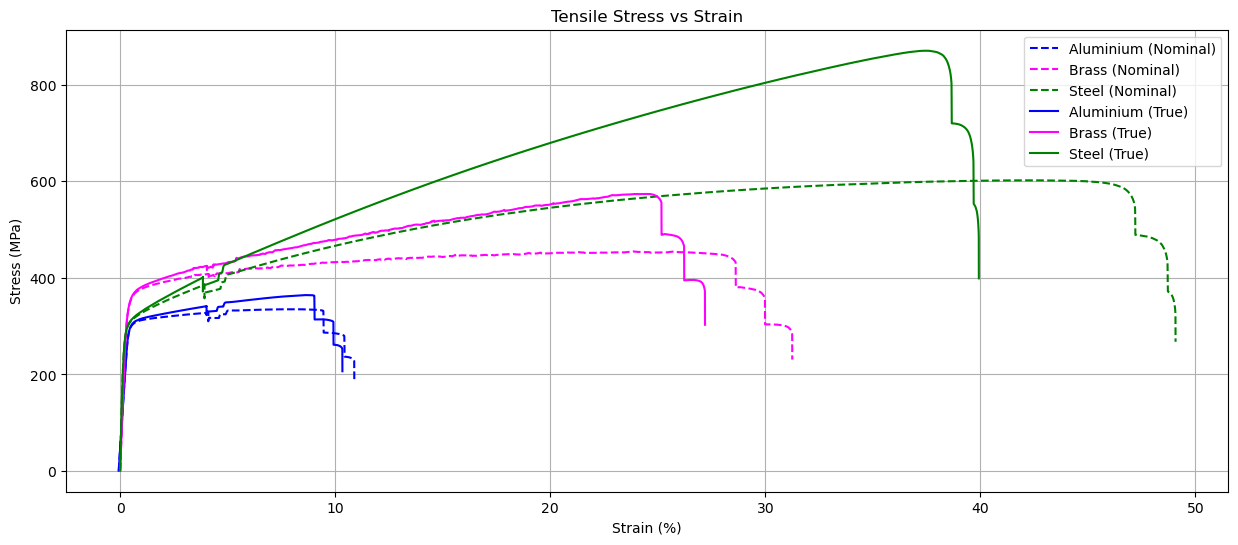

In [5]:
# Plot curves of both engineering and true stress vs strain

plt.figure(figsize=(15, 6))

plt.plot(A_avg["Tensile strain (Strain 1)/%"], A_avg["Nom Stress/MPa"], label="Aluminium (Nominal)", linestyle='--', color='blue')
plt.plot(B_avg["Tensile strain (Strain 1)/%"], B_avg["Nom Stress/MPa"], label="Brass (Nominal)", linestyle='--', color='magenta')
plt.plot(S_avg["Tensile strain (Strain 1)/%"], S_avg["Nom Stress/MPa"], label="Steel (Nominal)", linestyle='--', color='green')

plt.plot(A_avg["True Strain/%"], A_avg["True Stress/MPa"], label="Aluminium (True)", color='blue')
plt.plot(B_avg["True Strain/%"], B_avg["True Stress/MPa"], label="Brass (True)", color='magenta')
plt.plot(S_avg["True Strain/%"], S_avg["True Stress/MPa"], label="Steel (True)",color='green')

plt.xlabel("Strain (%)")
plt.ylabel("Stress (MPa)")
plt.title("Tensile Stress vs Strain")
plt.legend()
plt.grid(True)
base = Path("/Users/thomasfish/Desktop/University_Work/II_Materials/P2_Plasticity")
plt.savefig(base / "tensile_stress_strain.png", dpi=1000)
plt.show()

In [6]:
# Fit Voce parameters to the data

def voce(eps, sigma0, sigma_s, k):
    return sigma_s - (sigma_s - sigma0) * np.exp(-k * eps)

A_strain = A_avg["True Strain/%"].to_numpy()
A_stress = A_avg["True Stress/MPa"].to_numpy()
B_strain = B_avg["True Strain/%"].to_numpy()
B_stress = B_avg["True Stress/MPa"].to_numpy()
S_strain = S_avg["True Strain/%"].to_numpy()
S_stress = S_avg["True Stress/MPa"].to_numpy()

A_strain, A_stress = A_strain[1000:2750], A_stress[1000:2750]
B_strain, B_stress = B_strain[1000:17000], B_stress[1000:17000]
S_strain, S_stress = S_strain[750:25000], S_stress[750:25000]

#A_p0 = [100, 110, 200]
#B_p0 = [100, 135, 50]
#S_p0 = [100, 10, 100]

A_p0 = [100, 200, 0.1]
B_p0 = [100, 200, 0.1]
S_p0 = [100, 200, 0.1]

# --- Fit ---
A_params, A_cov = curve_fit(voce, A_strain, A_stress, p0=A_p0, maxfev=10000)
B_params, B_cov = curve_fit(voce, B_strain, B_stress, p0=B_p0, maxfev=10000)
S_params, S_cov = curve_fit(voce, S_strain, S_stress, p0=S_p0, maxfev=10000)
A_sigma0, A_sigma_s, A_k = A_params
B_sigma0, B_sigma_s, B_k = B_params
S_sigma0, S_sigma_s, S_k = S_params
print(f"Aluminium fitted parameters:\n  σ0 = {A_sigma0:.3f} MPa\n  σs = {A_sigma_s:.3f} MPa\n  k  = {A_k:.4f}")
print(f"Brass fitted parameters:\n  σ0 = {B_sigma0:.3f} MPa\n  σs = {B_sigma_s:.3f} MPa\n  k  = {B_k:.4f}")
print(f"Steel fitted parameters:\n  σ0 = {S_sigma0:.3f} MPa\n  σs = {S_sigma_s:.3f} MPa\n  k  = {S_k:.4f}")

# --- Predicted curve ---
A_strain_fit = np.linspace(A_strain.min(), A_strain.max(), 300)
A_stress_fit = voce(A_strain_fit, *A_params)
B_strain_fit = np.linspace(B_strain.min(), B_strain.max(), 300)
B_stress_fit = voce(B_strain_fit, *B_params)
S_strain_fit = np.linspace(S_strain.min(), S_strain.max(), 300)
S_stress_fit = voce(S_strain_fit, *S_params)

Aluminium fitted parameters:
  σ0 = 304.386 MPa
  σs = 381.748 MPa
  k  = 0.1585
Brass fitted parameters:
  σ0 = 372.166 MPa
  σs = 713.352 MPa
  k  = 0.0376
Steel fitted parameters:
  σ0 = 305.675 MPa
  σs = 1186.863 MPa
  k  = 0.0277


/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50076/3398462498.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(A_strain_fit, A_stress_fit, "r-", label="Aluminium Voce Fit", color='blue', linestyle='--')
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50076/3398462498.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(A_strain_fit, A_stress_fit, "r-", label="Aluminium Voce Fit", color='blue', linestyle='--')
/var/folders/r_/mmq2gnpx6qnbz26x3ypfrmvh0000gn/T/ipykernel_50076/3398462498.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(B_strain_fit, B_stress_fit, "r-", label="B

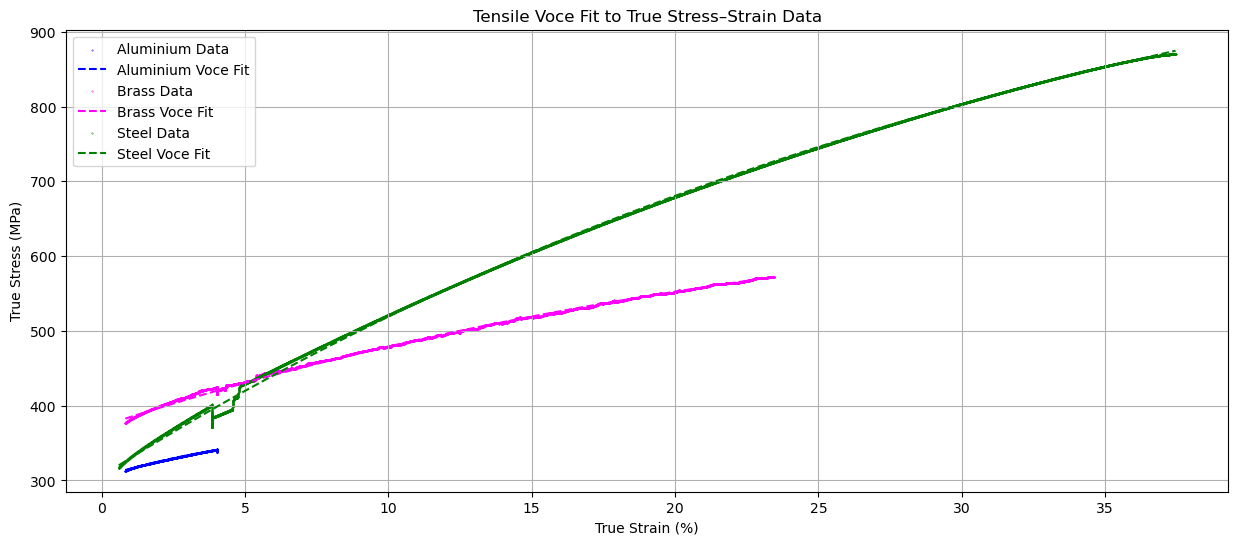

In [7]:
# Plot true stress data with the Voce curve fit

plt.figure(figsize=(15,6))

plt.scatter(A_strain, A_stress, s=0.1, label="Aluminium Data", color="blue", marker='o')
plt.plot(A_strain_fit, A_stress_fit, "r-", label="Aluminium Voce Fit", color='blue', linestyle='--')
plt.scatter(B_strain, B_stress, s=0.1, label="Brass Data", color="magenta", marker='o')
plt.plot(B_strain_fit, B_stress_fit, "r-", label="Brass Voce Fit", color='magenta', linestyle='--')
plt.scatter(S_strain, S_stress, s=0.1, label="Steel Data", color="green", marker='o')
plt.plot(S_strain_fit, S_stress_fit, "r-", label="Steel Voce Fit", color='green', linestyle='--')

plt.xlabel("True Strain (%)")
plt.ylabel("True Stress (MPa)")
plt.title("Tensile Voce Fit to True Stress–Strain Data")
plt.legend()
plt.grid(True)
base = Path("/Users/thomasfish/Desktop/University_Work/II_Materials/P2_Plasticity")
plt.savefig(base / "tensile_voce_fit+data.png", dpi=1000)
plt.show()